# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
#from scipy.misc import imread, imresize
import datetime
import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)

In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 64#experiment with the batch size

In [5]:
train_doc[:10]

array(['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180926_17_30_47_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_29_23_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180926_17_12_26_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_29_01_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180907_16_32_11_Pro_Stop Gesture_new;Stop Gesture_new;2\n'],
      dtype='<U88')

image size: (360, 360, 3)


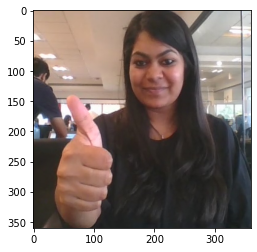

In [6]:
# view a random image from the training set
path = os.path.join('Project_data/train','*','*')
path = glob.glob(path)
rand_index = rn.randint(0, len(path))
image = imread(path[rand_index])

plt.imshow(image)
# Get the size of the image
print('image size:',image.shape)

In [14]:
classes = [i.split(';')[2][0] for i in list(train_doc)]
classes[0:5]

['1', '3', '0', '4', '0']

In [15]:
import pandas as pd
classes= pd.Series(classes)

In [16]:
classes.value_counts()

1    137
3    137
0    136
2    130
4    123
dtype: int64

There is no class imabalance

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
# specify image size and channels
img_channels = 3
img_rows = 120
img_cols = 120

# number of classes
nb_classes = 5

In [6]:
# Function to preprocess image
def preprocess_img(img,img_rows,img_cols):
    
    img = resize(img,(img_rows,img_cols),preserve_range=True).astype('uint8')
    
    img[:,:,0] = (img[:,:,0] - img[:,:,0].mean())/img[:,:,0].std()#normalise the image
    img[:,:,1] = (img[:,:,1] - img[:,:,1].mean())/img[:,:,1].std()#normalise the image
    img[:,:,2] = (img[:,:,2] - img[:,:,2].mean())/img[:,:,2].std()#normalise the image
                   
    #if mode == 'train':
    #    if np.random.randn() > 0:
    #        img = datagen.random_transform(img)
    return img

In [7]:
def generator(source_path, folder_list, batch_size,img_rows,img_cols,img_channels,nb_classes):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0,30,2)]#create a list of image numbers you want to use for a particular video
    x=len(img_idx)
    y=img_rows
    z=img_cols
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(np.floor(len(t)/batch_size))# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,img_channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,nb_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                            
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = preprocess_img(image,y,z)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        left_batch_size = int(len(t)%batch_size)
        batch_data = np.zeros((left_batch_size,x,y,z,img_channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((left_batch_size,nb_classes)) # batch_labels is the one hot representation of the output
        for folder in range(left_batch_size): # iterate over the lef_batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = preprocess_img(image,y,z)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

            
        


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 100# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, History
from tensorflow.keras import optimizers


In [11]:

#write your model here
#Build conv3D model
model = Sequential()
model.add(Conv3D(32, (3,3,3), activation='relu',padding='same',data_format="channels_last", 
                 input_shape=(15,img_rows,img_cols,img_channels)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(128, (3,3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Conv3D(128, (3,3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes,activation='softmax'))



In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 60, 60, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 58, 58, 64)     55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 58, 58, 64)     256       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 29, 29, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 27, 27, 128)    2

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
optimiser = optimizers.Adam(learning_rate=0.001)#write your optimizer


In [14]:
model.compile(optimizer=optimiser, loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])
#print (model.summary())

In [15]:
# Create callbacks list

#checkpoint
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
filepath = model_name + 'best_model.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

#Learning rate
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)# write the REducelronplateau code here


#loss history
# callback to append loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()

callbacks_list = [checkpoint, LR, history]


### Run ablation experiment

##### Check if model is working 

In [18]:
# Use 30 sequences to check whether model is working
ablation_train_doc = train_doc[:30]
ablation_test_doc = val_doc[:10]

num_train_sequences = len(ablation_train_doc) 
num_val_sequences   = len(ablation_test_doc)
batch_size = 32

#Generate ablation generator 
ablation_train_generator = generator(train_path, ablation_train_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)
ablation_val_generator = generator(val_path, ablation_test_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)



# calculate steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

    
print('steps_per_epoch',steps_per_epoch)
print('validation_steps',validation_steps)
# fit generator for 1 epoch
num_epochs =1

model.fit_generator(ablation_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=ablation_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


steps_per_epoch 1
validation_steps 1
Source path =  Project_data/train ; batch size = 32


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1/1 [==============================] - 18s 18s/step - loss: 2.6541 - categorical_accuracy: 0.2667 - val_loss: 26.1203 - val_categorical_accuracy: 0.1000

Epoch 00001: val_loss improved from inf to 26.12028, saving model to model_init_2022-07-1305_40_20.517844/best_model.h5


Model and generator are working without any error.

##### Overfit the data
Overfit data by using 60 sequences and run 20 epochs 

In [19]:
# Use 60 sequences to overfit and see if model is capable of learning
ablation_train_doc = train_doc[:60]
ablation_test_doc = val_doc[:20]

num_train_sequences = len(ablation_train_doc) 
num_val_sequences   = len(ablation_test_doc)
batch_size = 32


#Generate ablation generator 
ablation_train_generator = generator(train_path, ablation_train_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)
ablation_val_generator = generator(val_path, ablation_test_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)



# calculate steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

    
# fit generator for 20 epoch
num_epochs =20

model.fit_generator(ablation_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=ablation_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  Project_data/train ; batch size = 32
Epoch 1/20
2/2 [==============================] - 11s 9s/step - loss: 3.2842 - categorical_accuracy: 0.3500 - val_loss: 41.5797 - val_categorical_accuracy: 0.2000

Epoch 00001: val_loss did not improve from 26.12028
Epoch 2/20
2/2 [==============================] - 8s 7s/step - loss: 1.6862 - categorical_accuracy: 0.5167 - val_loss: 24.8828 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss improved from 26.12028 to 24.88280, saving model to model_init_2022-07-1305_40_20.517844/best_model.h5
Epoch 3/20
2/2 [==============================] - 8s 8s/step - loss: 2.0607 - categorical_accuracy: 0.4333 - val_loss: 47.8697 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 24.88280
Epoch 4/20
2/2 [==============================] - 8s 8s/step - loss: 1.3270 - categorical_accuracy: 0.5500 - val_loss: 89.9365 - val_categorical_accuracy: 0.2000

Epoch 00004: val_loss did not improve from 24.88280
Epoch 5/20
2/2

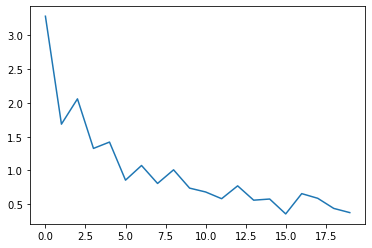

In [20]:
plt.plot(history.losses)

The model is learning from the data as the training accuracy is steadily increasing. Here validation accuracy also increased and then plateaus out.

###### Find the suitable batch size


In [16]:
# Updating the monitor value for checkpoint as val accuracy to save best model
#Create callbacks list

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
checkpoint1 = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

# instantiate a LossHistory() object to store histories
history = LossHistory()

callbacks_list = [checkpoint1, LR, history]



In [22]:

#Experiment for batch sizes 512,128,64
batch_size = 512


#compile the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

#Generate ablation generator 
train_generator = generator(train_path, train_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)
val_generator = generator(val_path, val_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)


# calculate steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

    

# fit generator for 1 epoch
num_epochs =1

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  Project_data/train ; batch size = 512


ResourceExhaustedError:  OOM when allocating tensor with shape[512,15,120,120,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/conv3d/Conv3D (defined at <ipython-input-22-e601df0de9ec>:30) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_5579]

Function call stack:
train_function


In [23]:

#Experiment for batch sizes 128
batch_size = 128


#compile the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

#Generate ablation generator 
train_generator = generator(train_path, train_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)
val_generator = generator(val_path, val_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)


# calculate steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

    

# fit generator for 1 epoch
num_epochs =1

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  Project_data/train ; batch size = 128


ResourceExhaustedError:  OOM when allocating tensor with shape[128,32,15,120,120] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential/max_pooling3d/MaxPool3D/MaxPool3DGrad (defined at <ipython-input-23-1b3074ca2857>:30) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_7190]

Function call stack:
train_function


In [24]:

#Experiment for batch sizes 64
batch_size = 64


#compile the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

#Generate ablation generator 
train_generator = generator(train_path, train_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)
val_generator = generator(val_path, val_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)


# calculate steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

    

# fit generator for 1 epoch
num_epochs =1

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  Project_data/train ; batch size = 64
1/1 [==============================] - 22s 22s/step - loss: 2.7969 - categorical_accuracy: 0.3281 - val_loss: 17.1805 - val_categorical_accuracy: 0.2656

Epoch 00001: val_categorical_accuracy improved from -inf to 0.26562, saving model to model_init_2022-07-1305_40_20.517844/best_model.h5


The best batch size is 64

In [ ]:
## The best batch size is 64
batch_size = 64

##### Test for the size of image
See the difference in accuracy and execution time when we use a lower size of image

In [25]:
# Giving reshape image value as 100
img_rows_1 =100
img_cols_1 = 100

In [26]:
# Create conv3D model with input size of 100x100
#write your model here
#Build conv3D model
model_1 = Sequential()
model_1.add(Conv3D(32, (3,3,3), activation='relu',padding='same',data_format="channels_last", 
                 input_shape=(15,img_rows_1,img_cols_1,img_channels)))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_1.add(Conv3D(64, (3,3,3),activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(1, 2, 2)))

model_1.add(Conv3D(128, (3,3,3), activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(1, 2, 2)))
model_1.add(Conv3D(128, (3,3,3), activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(1, 2, 2)))
model_1.add(Dropout(0.25))


model_1.add(Flatten())
model_1.add(Dense(512,activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1024,activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(nb_classes,activation='softmax'))



In [27]:
#compile the model
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 100, 100, 32)  128       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 7, 50, 50, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 5, 48, 48, 64)     55360     
_________________________________________________________________
batch_normalization_5 (Batch (None, 5, 48, 48, 64)     256       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 5, 24, 24, 64)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 3, 22, 22, 128)   

In [28]:
#Generate ablation generator 
ablation_train_doc = train_doc[:100]
ablation_test_doc = val_doc[:70]

num_train_sequences = len(ablation_train_doc) 
num_val_sequences   = len(ablation_test_doc)

#Generate ablation generator 
ablation_train_generator = generator(train_path, ablation_train_doc, batch_size,img_rows_1,img_cols_1,img_channels,nb_classes)
ablation_val_generator = generator(val_path, ablation_test_doc, batch_size,img_rows_1,img_cols_1,img_channels,nb_classes)


# calculate steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =LossHistory()

model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])


num_epochs =5
model_1.fit_generator(ablation_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=ablation_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  Project_data/train ; batch size = 64
Epoch 1/5
2/2 [==============================] - 21s 19s/step - loss: 3.0441 - categorical_accuracy: 0.2694 - val_loss: 6.2520 - val_categorical_accuracy: 0.1857

Epoch 00001: val_categorical_accuracy did not improve from 0.26562
Epoch 2/5
2/2 [==============================] - 13s 13s/step - loss: 2.9479 - categorical_accuracy: 0.2448 - val_loss: 4.4025 - val_categorical_accuracy: 0.1857

Epoch 00002: val_categorical_accuracy did not improve from 0.26562
Epoch 3/5
2/2 [==============================] - 19s 18s/step - loss: 2.0203 - categorical_accuracy: 0.3583 - val_loss: 4.3009 - val_categorical_accuracy: 0.2143

Epoch 00003: val_categorical_accuracy did not improve from 0.26562
Epoch 4/5
2/2 [==============================] - 13s 12s/step - loss: 2.4351 - categorical_accuracy: 0.2767 - val_loss: 3.7320 - val_categorical_accuracy: 0.2286

Epoch 00004: val_categorical_accuracy did not improve from 0.26562
Epoch 5/5
2/2 [=============

In [30]:
s_100_history = model_1.history.history

In [41]:
s_100_history.items()

dict_items([('loss', [3.270045757293701, 2.884335517883301, 2.0696394443511963, 2.4314746856689453, 1.9508140087127686]), ('categorical_accuracy', [0.23999999463558197, 0.25, 0.3499999940395355, 0.28999999165534973, 0.3700000047683716]), ('val_loss', [6.252042770385742, 4.402514934539795, 4.300943374633789, 3.732046127319336, 3.754687547683716]), ('val_categorical_accuracy', [0.18571428954601288, 0.18571428954601288, 0.2142857164144516, 0.22857142984867096, 0.2142857164144516]), ('lr', [1e-04, 1e-04, 1e-04, 1e-04, 1e-04])])

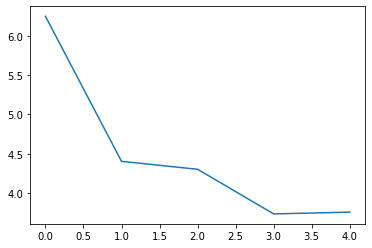

In [36]:
plt.plot(s_100_history['val_loss'])

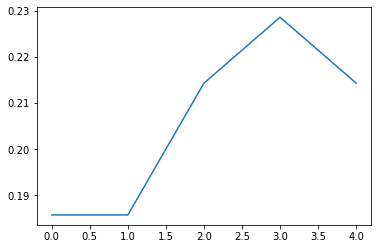

In [40]:
plt.plot(s_100_history['val_categorical_accuracy'])

In [18]:
#Test for image size 120x120. Train for 5 epochs
ablation_train_doc = train_doc[:100]
ablation_test_doc = val_doc[:70]

num_train_sequences = len(ablation_train_doc) 
num_val_sequences   = len(ablation_test_doc)

#Generate ablation generator 
ablation_train_generator = generator(train_path, ablation_train_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)
ablation_val_generator = generator(val_path, ablation_test_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)


# calculate steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


history =LossHistory()

model.compile(optimizer=optimiser, loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])


num_epochs =5
model.fit_generator(ablation_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=ablation_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  Project_data/train ; batch size = 64
Epoch 1/5
2/2 [==============================] - 38s 24s/step - loss: 3.7621 - categorical_accuracy: 0.2010 - val_loss: 40.1932 - val_categorical_accuracy: 0.2286

Epoch 00001: val_categorical_accuracy improved from -inf to 0.22857, saving model to model_init_2022-07-1306_36_26.674539/best_model.h5
Epoch 2/5
2/2 [==============================] - 13s 12s/step - loss: 2.8589 - categorical_accuracy: 0.3108 - val_loss: 36.7225 - val_categorical_accuracy: 0.2714

Epoch 00002: val_categorical_accuracy improved from 0.22857 to 0.27143, saving model to model_init_2022-07-1306_36_26.674539/best_model.h5
Epoch 3/5
2/2 [==============================] - 19s 19s/step - loss: 2.0641 - categorical_accuracy: 0.2315 - val_loss: 66.6400 - val_categorical_accuracy: 0.2000

Epoch 00003: val_categorical_accuracy did not improve from 0.27143
Epoch 4/5
2/2 [==============================] - 13s 12s/step - loss: 1.6782 - categorical_accuracy: 0.4087 - val_

In [19]:
model.history.history.items()

dict_items([('loss', [3.9629647731781006, 2.8721446990966797, 2.1168553829193115, 1.7461391687393188, 1.6888333559036255]), ('categorical_accuracy', [0.20000000298023224, 0.3100000023841858, 0.23000000417232513, 0.4099999964237213, 0.4399999976158142]), ('val_loss', [40.19321823120117, 36.72246551513672, 66.63996124267578, 84.28630828857422, 79.70287322998047]), ('val_categorical_accuracy', [0.22857142984867096, 0.27142858505249023, 0.20000000298023224, 0.27142858505249023, 0.2571428716182709]), ('lr', [0.001, 0.001, 0.001, 0.001, 0.001])])

In [20]:
s_120_history = model.history.history

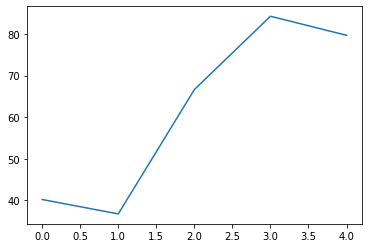

In [21]:
plt.plot(s_120_history['val_loss'])

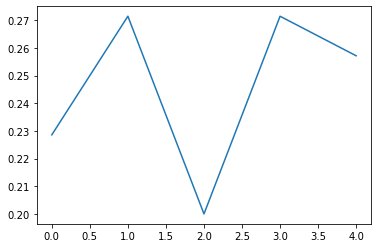

In [22]:
plt.plot(s_120_history['val_categorical_accuracy'])

I don't think there is much difference in the run time and accuracy better for shape 120x120. So we will go with size of 120x120

In [23]:
img_cols =120
img_rows =120
batch_size = 64

In [24]:
#Build conv3D model

#write your model here
#Build conv3D model
model = Sequential()
model.add(Conv3D(32, (3,3,3), activation='relu',padding='same',data_format="channels_last", 
                 input_shape=(15,img_rows,img_cols,img_channels)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(128, (3,3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Conv3D(128, (3,3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes,activation='softmax'))

model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 7, 60, 60, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 5, 58, 58, 64)     55360     
_________________________________________________________________
batch_normalization_5 (Batch (None, 5, 58, 58, 64)     256       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 5, 29, 29, 64)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 3, 27, 27, 128)   

In [25]:
#compile the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

In [26]:
# Create callbacks list

#checkpoint
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
#filepath = model_name + 'best_model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=False, save_weights_only=False, mode='max', period=1)
#checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

#Learning rate
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)# write the REducelronplateau code here


#loss history
# callback to append loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()

callbacks_list = [checkpoint, LR, history]


## Final model - Fit data

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [27]:
train_generator = generator(train_path, train_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)
val_generator = generator(val_path, val_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [34]:
print(f'no. of train docs:{len(train_doc)},no. of validation docs:{len(val_doc)}')

no. of train docs:663,no. of validation docs:100


In [32]:

num_train_sequences = len(train_doc) 
num_val_sequences   = len(val_doc)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
print(f'steps_per_epoch:{steps_per_epoch},validation_steps:{validation_steps}')

steps_per_epoch:11,validation_steps:2


Let us now fit the model.

In [35]:
# Train the model for 40 epochs

num_epochs =40

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  Project_data/train ; batch size = 64
Epoch 1/40
11/11 [==============================] - 128s 13s/step - loss: 3.0628 - categorical_accuracy: 0.2188 - val_loss: 35.5215 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_init_2022-07-1306_36_26.674539/model-00001-2.77409-0.23680-35.52149-0.22000.h5
Epoch 2/40
11/11 [==============================] - 69s 7s/step - loss: 1.9797 - categorical_accuracy: 0.3172 - val_loss: 27.2045 - val_categorical_accuracy: 0.3100

Epoch 00002: saving model to model_init_2022-07-1306_36_26.674539/model-00002-1.94477-0.31825-27.20455-0.31000.h5
Epoch 3/40
11/11 [==============================] - 72s 7s/step - loss: 1.6349 - categorical_accuracy: 0.3971 - val_loss: 23.8422 - val_categorical_accuracy: 0.2800

Epoch 00003: saving model to model_init_2022-07-1306_36_26.674539/model-00003-1.72078-0.36199-23.84218-0.28000.h5
Epoch 4/40
11/11 [==============================] - 71s 7s/step - loss: 1.4953 - categorical_accuracy: 0.4

11/11 [==============================] - 70s 7s/step - loss: 0.1107 - categorical_accuracy: 0.9595 - val_loss: 1.4718 - val_categorical_accuracy: 0.6100

Epoch 00030: saving model to model_init_2022-07-1306_36_26.674539/model-00030-0.12354-0.95777-1.47183-0.61000.h5
Epoch 31/40
11/11 [==============================] - 73s 7s/step - loss: 0.1070 - categorical_accuracy: 0.9737 - val_loss: 1.3608 - val_categorical_accuracy: 0.6400

Epoch 00031: saving model to model_init_2022-07-1306_36_26.674539/model-00031-0.09625-0.97134-1.36076-0.64000.h5
Epoch 32/40
11/11 [==============================] - 69s 7s/step - loss: 0.1047 - categorical_accuracy: 0.9660 - val_loss: 1.4204 - val_categorical_accuracy: 0.6300

Epoch 00032: saving model to model_init_2022-07-1306_36_26.674539/model-00032-0.09744-0.97285-1.42040-0.63000.h5
Epoch 33/40
11/11 [==============================] - 73s 7s/step - loss: 0.1109 - categorical_accuracy: 0.9708 - val_loss: 1.3414 - val_categorical_accuracy: 0.6400

Epoch 000

12:43- 1:31

In [36]:
model_opt = model.history.history

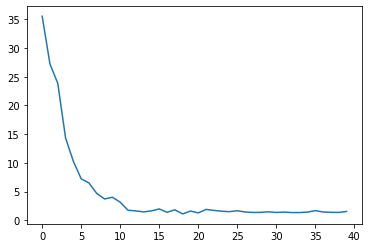

In [37]:
plt.plot(model_opt['val_loss'])

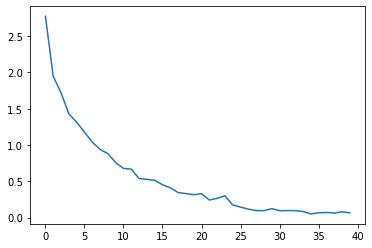

In [38]:
plt.plot(model_opt['loss'])

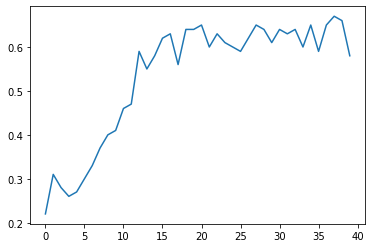

In [39]:
plt.plot(model_opt['val_categorical_accuracy'])

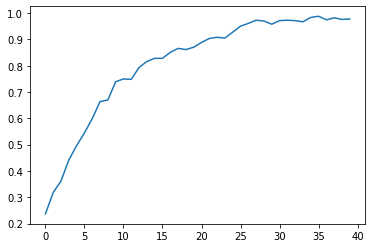

In [40]:
plt.plot(model_opt['categorical_accuracy'])

In [18]:
import pandas as pd

In [42]:
save_history = pd.DataFrame(model_opt)

In [43]:
save_history.head()

,loss,categorical_accuracy,val_loss,val_categorical_accuracy,lr
0,2.774092,0.236802,35.521488,0.22,0.001
1,1.944771,0.318250,27.204548,0.31,0.001
2,1.720781,0.361991,23.842182,0.28,0.001
3,1.429829,0.441931,14.317456,0.26,0.001
4,1.314737,0.496229,10.247937,0.27,0.001


In [45]:
save_history.to_csv('save_history.csv')

In [19]:
save_history = pd.read_csv('save_history.csv')
save_history.head()

,Unnamed: 0,loss,categorical_accuracy,val_loss,val_categorical_accuracy,lr
0,0,2.774092,0.236802,35.521488,0.22,0.001
1,1,1.944771,0.318250,27.204548,0.31,0.001
2,2,1.720781,0.361991,23.842182,0.28,0.001
3,3,1.429829,0.441931,14.317456,0.26,0.001
4,4,1.314737,0.496229,10.247937,0.27,0.001


In [20]:
import seaborn as sns

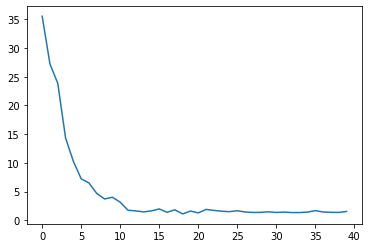

In [22]:
plt.plot(save_history['val_loss'])
plt.show()

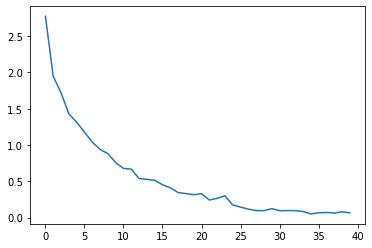

In [21]:
plt.plot(save_history[['loss']])
plt.show()

Training loss and validation losses are steadily decreasing till 20 epochs. Then it has become a plateau.

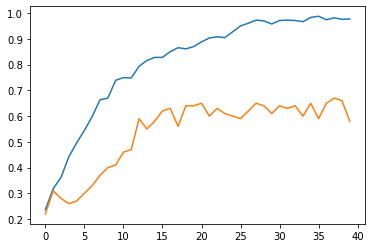

In [19]:
plt.plot(save_history[['categorical_accuracy','val_categorical_accuracy']])
plt.show()

The accuracy is increasing till 20 epochs , the training accuracy continue to increase but val accuracy becomes a plateau. Also the difference between the accuracy is nearly 20% at that time. Then model is overfitting. It will be better to take a model produced between 15 to 20 epochs.


In [26]:
save_history.iloc[10:25,:]

,Unnamed: 0,loss,categorical_accuracy,val_loss,val_categorical_accuracy,lr
10,10,0.677885,0.749623,3.145580,0.46,0.0010
11,11,0.668788,0.748115,1.741046,0.47,0.0010
12,12,0.539878,0.793364,1.632261,0.59,0.0010
13,13,0.527586,0.815988,1.460903,0.55,0.0010
14,14,0.515252,0.828054,1.630855,0.58,0.0010
15,15,0.452990,0.828054,1.971802,0.62,0.0010
16,16,0.411932,0.850679,1.383029,0.63,0.0010
17,17,0.345330,0.865762,1.820140,0.56,0.0010
18,18,0.331532,0.861237,1.104936,0.64,0.0010
19,19,0.316445,0.870287,1.604669,0.64,0.0010


We will choose 21st epoch model as output of conv3D model which has 65% val accuracy.

### Let's try CNN-RNN based architecture for gesture recognition

- We will use the same data generator. Because here also the input size is going to be (batch size * number of frames * image rows * image columns * channel size)
- We will use TimeDistributed layer to pass each frames of a video to Conv2D in a sequential manner.
- The output of Conv2D layer is going to be inputted to GRU. Here we are using GRU because it is lighter and we think GRU will be sufficient for this hand gesture recognition task.
- We will also make use of Transfer learning(VGG16) rather than a custom ConvNet for better result.
- The output layer will have a softmax function to multi-class classification.

- Steps
- 1. Recheck generator 
- 2. Design network. Give a new name, model_2
- 3. Give new model_name and create new check point
- 4. Initialse and create new call back list
- 5. Compile the model
- 6. Chek if the model is working
- 7. See if the model is overfitting
- 8. Train the model


In [10]:
#from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers  import GlobalMaxPooling2D
from tensorflow.keras.layers import GRU, TimeDistributed


In [11]:
def get_model():
    
    # Get base model: VGG16 
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows,img_cols,img_channels))
    
    trainable = 3
    for layer in base_model.layers[:-trainable]:
        layer.trainable = False
    for layer in base_model.layers[-trainable:]:
        layer.trainable = True
    # Get the output from the base model 
    base_model_ouput = base_model.output
    
    # Adding our own layers at the end
    # global max pooling: computes the max of all values in the feature map
    x = GlobalMaxPooling2D()(base_model_ouput)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model


In [12]:
# Get the model
convnet = get_model()

In [14]:
convnet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0     

In [15]:
# then create our final model
model_2 = Sequential()
# add the convnet with (15, 120, 120, 3) shape
model_2.add(TimeDistributed(convnet, input_shape=(15,img_rows,img_cols,img_channels)))

# Add GRU 
model_2.add(GRU(64))

# and finally, we make a decision network
model_2.add(Dense(1024, activation='relu'))
model_2.add(Dropout(.5))
model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(.5))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(.5))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(nb_classes, activation='softmax'))

In [16]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 512)           14714688  
_________________________________________________________________
gru (GRU)                    (None, 64)                110976    
_________________________________________________________________
dense (Dense)                (None, 1024)              66560     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6

In [13]:
optimiser = optimizers.Adam(learning_rate=0.001)#write your optimizer


In [23]:


model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])


In [24]:

# Create callbacks list

#checkpoint
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
filepath = model_name + 'best_model.h5'

# for experiments saving only best model
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

#Learning rate
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)# write the REducelronplateau code here


#loss history
# callback to append loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()

callbacks_list = [checkpoint, LR, history]


##### Check if cnn-rnn model is working 

In [18]:


# Use 30 sequences to check whether model is working
ablation_train_doc = train_doc[:30]
ablation_test_doc = val_doc[:10]

num_train_sequences = len(ablation_train_doc) 
num_val_sequences   = len(ablation_test_doc)
batch_size = 32

#Generate ablation generator 
ablation_train_generator = generator(train_path, ablation_train_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)
ablation_val_generator = generator(val_path, ablation_test_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)



# calculate steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

    
print('steps_per_epoch',steps_per_epoch)
print('validation_steps',validation_steps)
# fit generator for 1 epoch
num_epochs =1

model_2.fit_generator(ablation_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=ablation_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


steps_per_epoch 1
validation_steps 1
Source path =  Project_data/train ; batch size = 32


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1/1 [==============================] - 64s 64s/step - loss: 1.8562 - categorical_accuracy: 0.1333 - val_loss: 1.6252 - val_categorical_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 1.62518, saving model to model_init_2022-07-1309_44_18.593814/best_model.h5


##### Overfit the data
Overfit data by using 60 sequences and run 20 epochs 


In [25]:

# Use 60 sequences to overfit and see if model is capable of learning
ablation_train_doc = train_doc[:60]
ablation_test_doc = val_doc[:20]

num_train_sequences = len(ablation_train_doc) 
num_val_sequences   = len(ablation_test_doc)
batch_size = 32


#Generate ablation generator 
ablation_train_generator = generator(train_path, ablation_train_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)
ablation_val_generator = generator(val_path, ablation_test_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)



# calculate steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

    
# fit generator for 20 epoch
num_epochs =20

model_2.fit_generator(ablation_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=ablation_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  Project_data/train ; batch size = 32
Epoch 1/20
2/2 [==============================] - 34s 16s/step - loss: 1.8800 - categorical_accuracy: 0.1528 - val_loss: 1.5998 - val_categorical_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 1.59979, saving model to model_init_2022-07-1310_44_27.455737/best_model.h5
Epoch 2/20
2/2 [==============================] - 10s 10s/step - loss: 1.5619 - categorical_accuracy: 0.3146 - val_loss: 1.5952 - val_categorical_accuracy: 0.1000

Epoch 00002: val_loss improved from 1.59979 to 1.59516, saving model to model_init_2022-07-1310_44_27.455737/best_model.h5
Epoch 3/20
2/2 [==============================] - 10s 9s/step - loss: 1.6999 - categorical_accuracy: 0.2056 - val_loss: 1.6183 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.59516
Epoch 4/20
2/2 [==============================] - 10s 9s/step - loss: 1.5789 - categorical_accuracy: 0.1965 - val_loss: 1.6455 - val_categorical_accuracy: 0.2000

E

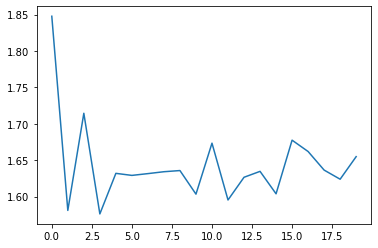

In [26]:
plt.plot(model_2.history.history['loss'])

In [28]:
conv_rnn_m1 = model_2.history.history

Looks like model is not learning here. We will have to modify our model.

### Increase GRU units

In [30]:
# Get the model
convnet = get_model()
# then create our final model
model_3 = Sequential()
# add the convnet with (15, 120, 120, 3) shape
model_3.add(TimeDistributed(convnet, input_shape=(15,img_rows,img_cols,img_channels)))

# Add GRU 
model_3.add(GRU(100))
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 15, 512)           14714688  
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               184200    
Total params: 14,898,888
Trainable params: 4,903,816
Non-trainable params: 9,995,072
_________________________________________________________________


In [31]:

#model_3.add(GRU(100))
# and finally, we make a decision network
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(.5))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(.5))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(nb_classes, activation='softmax'))
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 15, 512)           14714688  
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               184200    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               51712     
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [33]:
#Use 60 sequences to overfit and see if model is capable of learning
ablation_train_doc = train_doc[:60]
ablation_test_doc = val_doc[:20]

num_train_sequences = len(ablation_train_doc) 
num_val_sequences   = len(ablation_test_doc)
batch_size = 32


#Generate ablation generator 
ablation_train_generator = generator(train_path, ablation_train_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)
ablation_val_generator = generator(val_path, ablation_test_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)



# calculate steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

    
# fit generator for 20 epoch
num_epochs =10

model_3.fit_generator(ablation_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=ablation_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  Project_data/train ; batch size = 32
Epoch 1/10
2/2 [==============================] - 17s 15s/step - loss: 1.7790 - categorical_accuracy: 0.2597 - val_loss: 1.6832 - val_categorical_accuracy: 0.2000

Epoch 00001: val_loss did not improve from 1.59516
Epoch 2/10
2/2 [==============================] - 16s 15s/step - loss: 1.6447 - categorical_accuracy: 0.1965 - val_loss: 1.6742 - val_categorical_accuracy: 0.1500

Epoch 00002: val_loss did not improve from 1.59516
Epoch 3/10
2/2 [==============================] - 16s 15s/step - loss: 1.7144 - categorical_accuracy: 0.1854 - val_loss: 1.6999 - val_categorical_accuracy: 0.1000

Epoch 00003: val_loss did not improve from 1.59516
Epoch 4/10
2/2 [==============================] - 13s 12s/step - loss: 1.7577 - categorical_accuracy: 0.1632 - val_loss: 1.6530 - val_categorical_accuracy: 0.1500

Epoch 00004: val_loss did not improve from 1.59516
Epoch 5/10
2/2 [==============================] - 10s 10s/step - loss: 1.5893 - categori

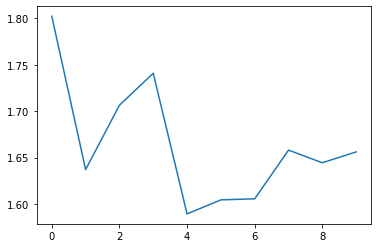

In [34]:
plt.plot(model_3.history.history['loss'])

### Increase GRU units and run ablation with more data for 10 epochs

In [16]:
#Get the model
convnet = get_model()
# then create our final model
model_4 = Sequential()
# add the convnet with (15, 120, 120, 3) shape
model_4.add(TimeDistributed(convnet, input_shape=(15,img_rows,img_cols,img_channels)))

# Add GRU 
model_4.add(GRU(120))
model_4.add(Dense(1024, activation='relu'))
model_4.add(Dropout(.5))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(.5))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(nb_classes, activation='softmax'))
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 512)           14714688  
_________________________________________________________________
gru_1 (GRU)                  (None, 120)               228240    
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              123904    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [18]:
optimiser = optimizers.Adam(learning_rate=0.001)#write your optimizer

model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])



# Create callbacks list

#checkpoint
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
filepath = model_name + 'best_model.h5'

# for experiments saving only best model
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

#Learning rate
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001)# write the REducelronplateau code here


#loss history
# callback to append loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()

callbacks_list = [checkpoint, LR, history]


In [19]:
#Use 120 sequences to overfit and see if model is capable of learning
ablation_train_doc = train_doc[:200]
ablation_test_doc = val_doc[:70]

num_train_sequences = len(ablation_train_doc) 
num_val_sequences   = len(ablation_test_doc)
batch_size = 64


#Generate ablation generator 
ablation_train_generator = generator(train_path, ablation_train_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)
ablation_val_generator = generator(val_path, ablation_test_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)



# calculate steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

    
# fit generator for 10 epoch
num_epochs =10

model_4.fit_generator(ablation_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=ablation_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  Project_data/train ; batch size = 64
Epoch 1/10
4/4 [==============================] - 52s 16s/step - loss: 1.7127 - categorical_accuracy: 0.1716 - val_loss: 1.6370 - val_categorical_accuracy: 0.1857

Epoch 00001: val_categorical_accuracy improved from -inf to 0.18571, saving model to model_init_2022-07-1313_21_25.851815/best_model.h5
Epoch 2/10
4/4 [==============================] - 40s 13s/step - loss: 1.6658 - categorical_accuracy: 0.2314 - val_loss: 1.6266 - val_categorical_accuracy: 0.2286

Epoch 00002: val_categorical_accuracy improved from 0.18571 to 0.22857, saving model to model_init_2022-07-1313_21_25.851815/best_model.h5
Epoch 3/10
4/4 [==============================] - 47s 15s/step - loss: 1.6549 - categorical_accuracy: 0.1771 - val_loss: 1.6206 - val_categorical_accuracy: 0.2286

Epoch 00003: val_categorical_accuracy did not improve from 0.22857
Epoch 4/10
4/4 [==============================] - 40s 13s/step - loss: 1.6083 - categorical_accuracy: 0.2239 - val

In [22]:
model_4.history.history

{'loss': [1.6932969093322754,
  1.6645116806030273,
  1.6505084037780762,
  1.5985174179077148,
  1.630064845085144,
  1.667696475982666,
  1.6626020669937134,
  1.6407848596572876,
  1.6387741565704346,
  1.6098661422729492],
 'categorical_accuracy': [0.17000000178813934,
  0.23999999463558197,
  0.1850000023841858,
  0.2199999988079071,
  0.23999999463558197,
  0.2199999988079071,
  0.23000000417232513,
  0.20000000298023224,
  0.20499999821186066,
  0.23999999463558197],
 'val_loss': [1.636966347694397,
  1.626579761505127,
  1.6205730438232422,
  1.6187820434570312,
  1.6060731410980225,
  1.6172561645507812,
  1.631083369255066,
  1.6185665130615234,
  1.599355697631836,
  1.6157442331314087],
 'val_categorical_accuracy': [0.18571428954601288,
  0.22857142984867096,
  0.22857142984867096,
  0.18571428954601288,
  0.24285714328289032,
  0.22857142984867096,
  0.22857142984867096,
  0.22857142984867096,
  0.22857142984867096,
  0.15714286267757416],
 'lr': [0.001, 0.001, 0.001, 0.00

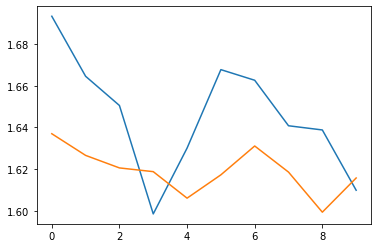

In [24]:
plt.plot(model_4.history.history['loss'])
plt.plot(model_4.history.history['val_loss'])

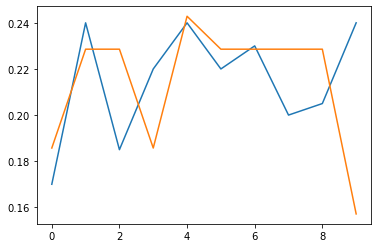

In [25]:
plt.plot(model_4.history.history['categorical_accuracy'])
plt.plot(model_4.history.history['val_categorical_accuracy'])

#### Add one more layer of GRU

In [26]:
#Get the model
convnet = get_model()
# then create our final model
model_5 = Sequential()
# add the convnet with (15, 120, 120, 3) shape
model_5.add(TimeDistributed(convnet, input_shape=(15,img_rows,img_cols,img_channels)))

# Add GRU 
model_5.add(GRU(120,return_sequences=True))
model_5.add(GRU(120))

model_5.add(Dense(1024, activation='relu'))
model_5.add(Dropout(.5))
model_5.add(Dense(128, activation='relu'))
model_5.add(Dropout(.5))
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(nb_classes, activation='softmax'))
model_5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 15, 512)           14714688  
_________________________________________________________________
gru_2 (GRU)                  (None, 15, 120)           228240    
_________________________________________________________________
gru_3 (GRU)                  (None, 120)               87120     
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              123904    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [ ]:
#optimiser = optimizers.Adam(learning_rate=0.001)#write your optimizer

#model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', 
#              metrics=['categorical_accuracy'])



In [27]:


# Create callbacks list

#checkpoint
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
filepath = model_name + 'best_model.h5'

# for experiments saving only best model
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

#Learning rate
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001)# write the REducelronplateau code here


#loss history
# callback to append loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()

callbacks_list = [checkpoint, LR, history]





In [29]:
#Use 120 sequences to overfit and see if model is capable of learning
ablation_train_doc = train_doc[:200]
ablation_test_doc = val_doc[:70]

num_train_sequences = len(ablation_train_doc) 
num_val_sequences   = len(ablation_test_doc)
batch_size = 64


#Generate ablation generator 
ablation_train_generator = generator(train_path, ablation_train_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)
ablation_val_generator = generator(val_path, ablation_test_doc, batch_size,img_rows,img_cols,img_channels,nb_classes)



# calculate steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

    
# fit generator for 10 epoch
num_epochs =10

model_5.fit_generator(ablation_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=ablation_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  Project_data/train ; batch size = 64
Epoch 1/10
4/4 [==============================] - 49s 15s/step - loss: 1.6876 - categorical_accuracy: 0.1695 - val_loss: 1.6146 - val_categorical_accuracy: 0.2143

Epoch 00001: val_categorical_accuracy improved from -inf to 0.21429, saving model to model_init_2022-07-1313_21_25.851815/best_model.h5
Epoch 2/10
4/4 [==============================] - 33s 11s/step - loss: 1.6238 - categorical_accuracy: 0.2619 - val_loss: 1.5987 - val_categorical_accuracy: 0.1857

Epoch 00002: val_categorical_accuracy did not improve from 0.21429
Epoch 3/10
4/4 [==============================] - 45s 15s/step - loss: 1.6160 - categorical_accuracy: 0.1982 - val_loss: 1.6098 - val_categorical_accuracy: 0.2286

Epoch 00003: val_categorical_accuracy improved from 0.21429 to 0.22857, saving model to model_init_2022-07-1313_21_25.851815/best_model.h5
Epoch 4/10
4/4 [==============================] - 42s 13s/step - loss: 1.6176 - categorical_accuracy: 0.2312 - val

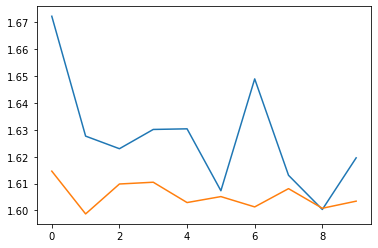

In [30]:
plt.plot(model_5.history.history['loss'])
plt.plot(model_5.history.history['val_loss'])


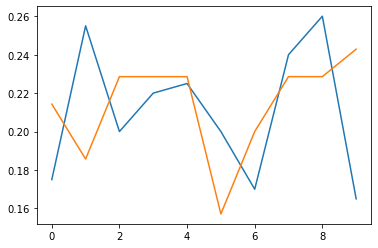

In [31]:
plt.plot(model_5.history.history['categorical_accuracy'])
plt.plot(model_5.history.history['val_categorical_accuracy'])